In [42]:
import pyImport as f

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from numpy import linspace
from numpy import meshgrid
from matplotlib import animation
from matplotlib import text


import numpy as np
import pandas as pd

import itertools
from collections import Counter
import pickle

from datetime import datetime

from Data import Data
from sklearn.cluster import AgglomerativeClustering

In [3]:
n_components = 6
level = 12

In [4]:
window = 10

In [5]:
shift = 5

In [6]:
temporal_limits = {"time_min":datetime(1948, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

d = Data('GPCC_half.nc','precip',temporal_limits, missing_value=-9.96921e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

d = Data('air_monthly_mean_africa.nc','air', missing_value=-9.96921e+36)

result_air = d.get_data()
lon_list_air = d.get_lon_list()
lat_list_air = d.get_lat_list()
lon_air = d.get_lon()
lat_air = d.get_lat()


air_list = list(zip(lon_list_air,lat_list_air))

pre_list = list(zip(lon_list,lat_list))

clean_list = []
Idx = []
for i in range(len(air_list)):
    temp = f.neighbour_average(pre_list,pd.DataFrame(result),air_list[i][0], air_list[i][1])
    if temp.shape:
        clean_list.append(temp)
        Idx.append(i)

In [7]:
precipitation = np.array(clean_list)#/np.array(clean_list).std()
precipitation = pd.DataFrame(np.transpose(precipitation))

result_air = pd.DataFrame(result_air)
temperature = result_air.iloc[:,Idx]

#temperature = temperature/temperature.stack().std()

precipitation.columns = temperature.columns

In [8]:
clusters_air = np.zeros(len(lon_list_air))
clusters_air.fill(-1)

clusters_air[Idx] = 1

index = np.argwhere(clusters_air == -1)

In [9]:
clusters_air = np.delete(clusters_air, index)
lat_list_air = np.delete(lat_list_air, index)
lon_list_air = np.delete(lon_list_air, index)

In [21]:
n_items = precipitation.shape[1]

In [78]:
similarity = np.zeros((5,5))

In [10]:
def find_original_cluster(original_clusters, clusters):
    similarity = np.zeros((len(set(original_clusters)),len(set(clusters))))
    result = np.zeros(len(original_clusters))
    count_i = 0 
    count_j = 0
    for i in set(original_clusters): 
        index = np.where(original_clusters == i)[0]
        for j in set(clusters):         
            class_Idx = np.where(clusters == j)[0]
            similarity[count_i,count_j] = len(np.intersect1d(index,class_Idx))
            count_j += 1
        count_j = 0    
        count_i += 1
        
    for i in range(len(set(original_clusters))):
        m = np.argmax(similarity[i,:])
        Idx = np.where(clusters == m)[0]
        result[Idx] = i
    return(result)

In [22]:
original_clusters = np.zeros(n_items)

In [23]:
k = 0

In [24]:
onset = k*shift*12
end = onset + window * 12 -1

precipitation_temp = precipitation.loc[onset:end]
temperature_temp = temperature.loc[onset:end]

combined_vertically = pd.concat([temperature_temp,precipitation_temp],ignore_index=True,sort=False, axis=0)
clustering = AgglomerativeClustering(n_clusters=n_components).fit(combined_vertically.transpose())
original_clusters = clustering.labels_ 

In [32]:
window = 10
shift = 5

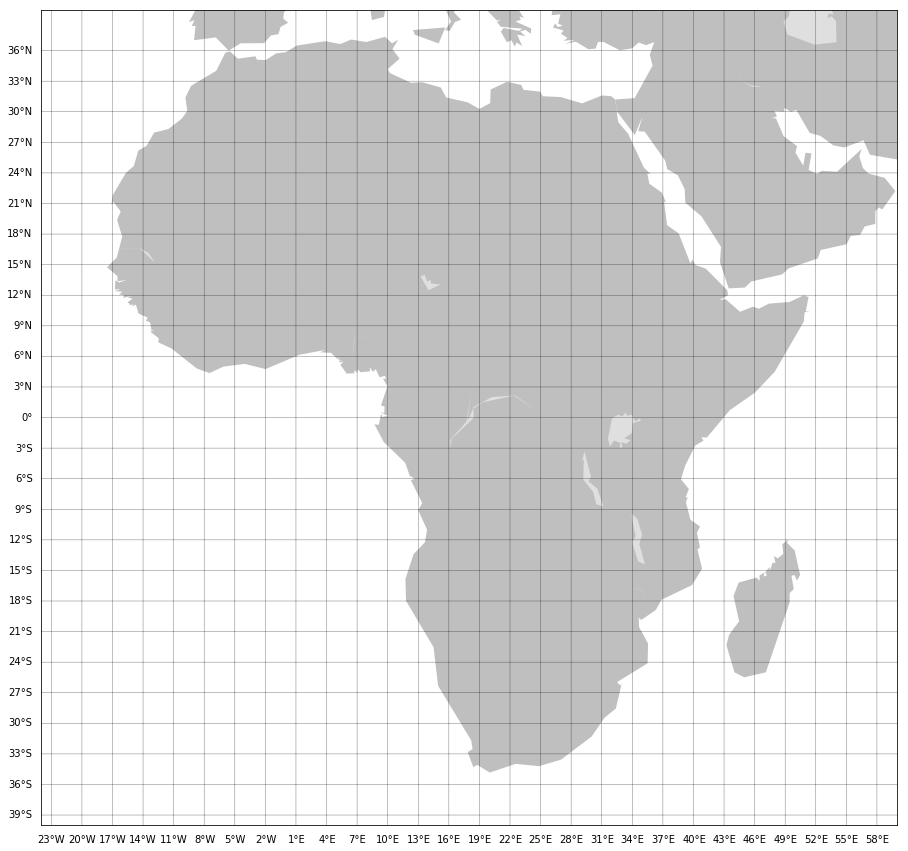

In [45]:
#lon = np.arange(-23.75,60.0,2.5)


fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)



def animate(k, original_clusters):
    
    colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
    '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
    '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
    
    onset = k*shift*12
    end = onset + window * 12 -1
    
    #plt.title("1946")
    #text(0.1, 0.9,'matplotlib', ha='center', va='center', transform=ax.transAxes)
    precipitation_temp = precipitation.loc[onset:end]
    temperature_temp = temperature.loc[onset:end]

    combined_vertically = pd.concat([temperature_temp,precipitation_temp],ignore_index=True,sort=False, axis=0)
    clustering = AgglomerativeClustering(n_clusters=n_components).fit(combined_vertically.transpose())
    #if k==0:
    #    similarity = clustering.labels_
    #else:
    #    similarity = find_original_cluster(original_clusters, clustering.labels_)
               
    df_air = pd.DataFrame({"lons":lon_list_air,"lats":lat_list_air,"clusters":clustering.labels_})
    
    clusters_air = clustering.labels_ 
    #clusters_air = similarity 

    lon_temp = df_air["lons"].values
    lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
    df_air["lons"] = lon_temp

    df_list = []
    for j in range(len(set(clusters_air))):
        df_list.append(pd.DataFrame(columns=df_air.columns))
    #print(clusters_air)
    
    i = 0
    for j in set(clusters_air):
        values = df_air["clusters"].values  
        Idx = np.where(values == j)[0]
        df_list[i] = df_air.iloc[Idx,:]
        df_list[i]["values"] = values[Idx]

        lons = df_list[i]["lons"].values
        lats = df_list[i]["lats"].values
        x,y = m(lons, lats)
        cs = ax.scatter(x, y, alpha=0.9, s=200, label = i)
        i+=1
    
    return cs
    

In [46]:
anim = animation.FuncAnimation(fig, animate,frames=10, interval=3000, fargs=(original_clusters,))
anim.save('cluster1.mp4')

In [118]:
onset = i*shift*12

In [119]:
end = onset + window * 12 -1

In [122]:
precipitation_temp = precipitation.loc[onset:end]
temperature_temp = temperature.loc[onset:end]

In [125]:
combined_vertically = pd.concat([temperature_temp,precipitation_temp],ignore_index=True,sort=False, axis=0)
clustering = AgglomerativeClustering(n_clusters=n_components).fit(combined_vertically.transpose())

df_air = pd.DataFrame({"lons":lon_list_air,"lats":lat_list_air,"clusters":clustering.labels_ })

clusters_air = clustering.labels_ 

lon_temp = df_air["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_air["lons"] = lon_temp

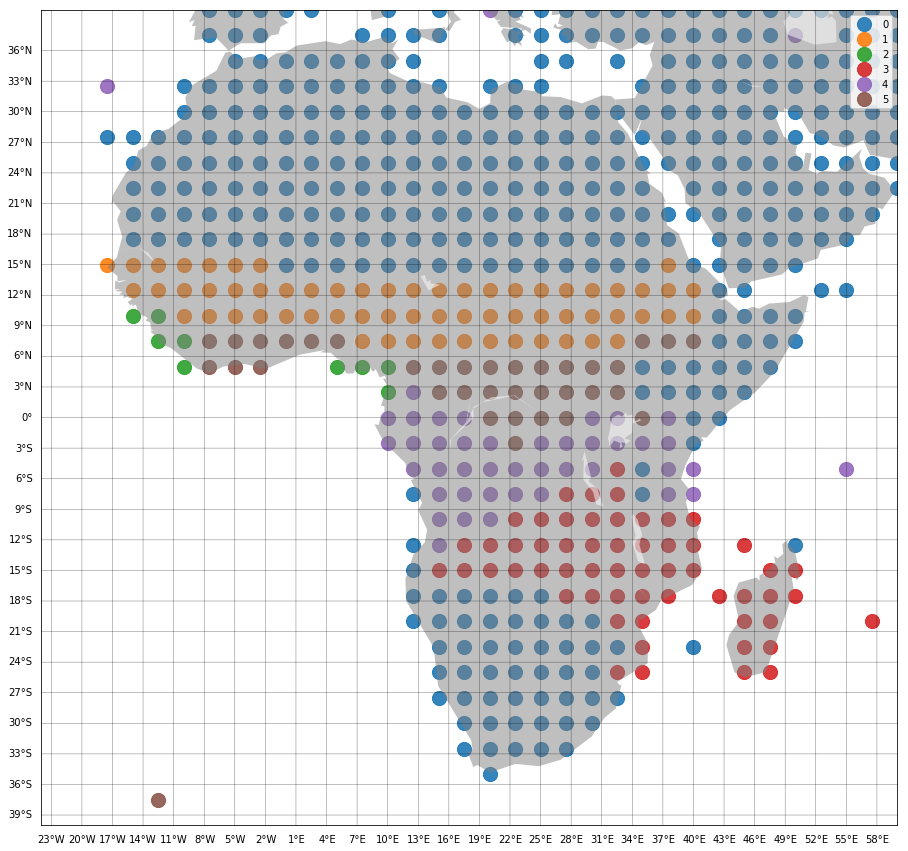

In [131]:
df_list = []
for j in range(len(set(clusters_air))):
    df_list.append(pd.DataFrame(columns=df_air.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
map = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
map.fillcontinents(color='grey', alpha=0.5)
map.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
map.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)

i = 0
for j in set(clusters_air):
    values = df_air["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df_air.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    cs = ax.scatter(x, y, alpha=0.9, s=200, label = i)
    i+=1

    
plt.legend()
plt.show()

In [136]:
plt(cs)

TypeError: 'module' object is not callable

In [ ]:
precipitation = np.array(clean_list)#/np.array(clean_list).std()
precipitation = pd.DataFrame(np.transpose(precipitation))

result_air = pd.DataFrame(result_air)
temperature = result_air.iloc[:,Idx]

#temperature = temperature/temperature.stack().std()

precipitation.columns = temperature.columns

combined_vertically = pd.concat([temperature,precipitation],ignore_index=True,sort=False, axis=0)

clustering = AgglomerativeClustering(n_clusters=n_components).fit(combined_vertically.transpose())
#clustering = KMeans(n_clusters=n_components).fit(combined_vertically.transpose())

clusters_air = np.zeros(len(lon_list_air))
clusters_air.fill(-1)

clusters_air[Idx] = clustering.labels_ 

index = np.argwhere(clusters_air == -1)

clusters_air = np.delete(clusters_air, index)
lat_list_air = np.delete(lat_list_air, index)
lon_list_air = np.delete(lon_list_air, index)

df_air = pd.DataFrame({"lons":lon_list_air,"lats":lat_list_air,"clusters":clusters_air})

lon_temp = df_air["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_air["lons"] = lon_temp